In [2]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import pycrs
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import glob
import os
from prepare_data import *

## Adm0
https://gadm.org/download_country_v3.html

In [3]:
countries = ['Bangladesh',
             'Ethiopia',
             'Jordan',
             'Kenya',
             'Pakistan',
             'Rwanda',
             'Sudan',
             'South Sudan',
             'Tanzania',
             'Uganda']

In [5]:
adm0 = {}
folders = next(os.walk('../data/raw/gadm'))[1]
for folder, country in zip(folders, countries):
    path = '../data/raw/gadm/' + folder
    files = glob.glob(path + "/*.shp")
    for file in files:
        if '_0.shp' in file:
            adm0[country] = gpd.read_file(file)
adm0 = pd.concat(adm0, axis=0).reset_index(drop=True)

## GHS-POP

### Load the data

In [7]:
file = '../data/raw/worldpop/ppp_2020_1km_Aggregated.tif'
data = rasterio.open(file)

### Do masking

In [9]:
for country in countries:
    gdf = adm0[adm0['NAME_0'] == country]
    coords = getFeatures(gdf)
    out_img, out_transform = rasterio.mask.mask(dataset=data, shapes=coords, crop=True)
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    with rasterio.open(f'../data/processed/worldpop/{country}.tif', "w", **out_meta) as dest:
        dest.write(out_img)

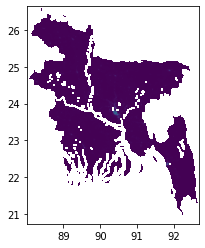

In [6]:
# Check the result
country = 'Bangladesh'
data = rasterio.open(f'../data/processed/worldpop/{country}.tif')
array = rxr.open_rasterio(f'../data/processed/worldpop/{country}.tif')
show(data);